## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 8: Spatio-temporal Gassusian Process (STGP) Modelling Background

This notebook provides a follow-on tutorial on using Gaussian Process (GP) to infer spatio-temporal variation of sea-level change based on relative sea-level (RSL) data. Please make sure you understand how to do temporal GP in PlaeoSTeHM before starting this tutorial.

We know that paleo environment varies not only temorally but also **spatially**, therefore incorporating spatial information into inference algorithm is an important step forward. Therefore, instead of assumping paleo-environmental data (i.e., sea level, temperature, precipitation etc) change independently at each site (i.e., data in different sites locate closely together can be completely different), spatio-temporal GP (SP-GP) can capture spatial information into final inference results. In other words, it assumes the nearby sites should experience similar variations compared to sites that are far away from them. And an important advantage of SP-GP is that it can infer spatio-temporal field of environmental change and therefore enable spatial analysis!

This tutorial will cover:

**&#10148; 1.** Geographical squared distance matrix and spatial covariance matrix

**&#10148; 2.** Spatio-temporal kernel

**&#10148; 3.** STGP on US east coast 


### 1. Geographical squared distance matrix and spatial covariance matrix

**Geographical squared distance matrix**

To start let's think about how should we incorporate spatial information into account. A stratightforward way is to use longitude and latitude values as two input variables to GP regression just like what we did for time data. However, in real-world the distance calculated between longitude and latitude can be problematic since Earth is actually a sphere instead of a plate. For example, the distance between (19 $\degree$ W, 1 $\degree$ N) and (20 $\degree$ W, 1 $\degree$ N) is 1 $\degree$, and the distance between (19 $\degree$ W, 80 $\degree$ N) and (20 $\degree$ W, 80 $\degree$ N) is $\degree$ is also one degree. But in fact, the former distance is around 111.3 km and the latter distance is only 19.4 km! In this case, it's not a good idea to use longitude and latitude here.

Instead, we should use the true geographical distance between each two data points to construct a sqaured distance matrix and covariance matrix, which can therefore capture their correlation purely based on their geographical proximity. Another good news is that, instead of adding two extra variables of longitude and latitude, we can use just one input variable to present spatial information (i.e., geographical distance). To calculate geographical distance, we can use the following equations (you don't necessarily need to understand them):

$$ 
\Delta\phi = \phi_2 - \phi_1 \\
\Delta\theta = \theta_2 - \theta_1 \\
a = \sin^2(\frac{\Delta\theta}{2})  + \cos(\theta_1) \cdot \cos(\theta_2) \cdot \sin^2(\frac{\Delta\phi}{2}) \\
\text{GeoD}= 2 \cdot \text{atan2}(\sqrt{a}, \sqrt{1 - a}) 
$$
where $\theta_{1}$ and $\phi_{1}$ are the latitude and longitude of the first point in radians, $\theta_{2}$ and $\phi_{2}$ are the latitude and longitude of the second point in radians. GeoD represents geographical distance between these two points in raians, which varies between 0 and 2 $\pi$ (roughly 6.283). If you wish, you can multiply this with Earth radius (6371 km) to get the real-world distance. 

Based on this equation, we can calculate the geographical sqaured distance matrix ($D_{Geo}$) for each data location ($x$) as we did for time data:

$$
D_{Geo}^2 = \begin{pmatrix}
  GeoD(x_{1},x_{1})^2      & GeoD(x_{1},x_{2})^2   & \cdots  & GeoD(x_{1},x_{n})^2  \\
  GeoD(x_{2},x_{1})^2       &   GeoD(x_{2},x_{2})^2     & \cdots  & GeoD(x_{2},x_{n})^2  \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  GeoD(x_{n},x_{1})^2        & GeoD(x_{n},x_{2})^2     & \cdots  & GeoD(x_{n},x_{n})^2  \\
\end{pmatrix}
$$
where $GeoD(x_{1},x_{2})$ defines geographical distance between data locations 1 and 2. 

You can do this in PaleoSTeHM by calling `cal_geo_dist2` funciton. Let's try with sea-level data from Ashe et al., (2019, and references therein).


In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os

sys.path.append('../../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

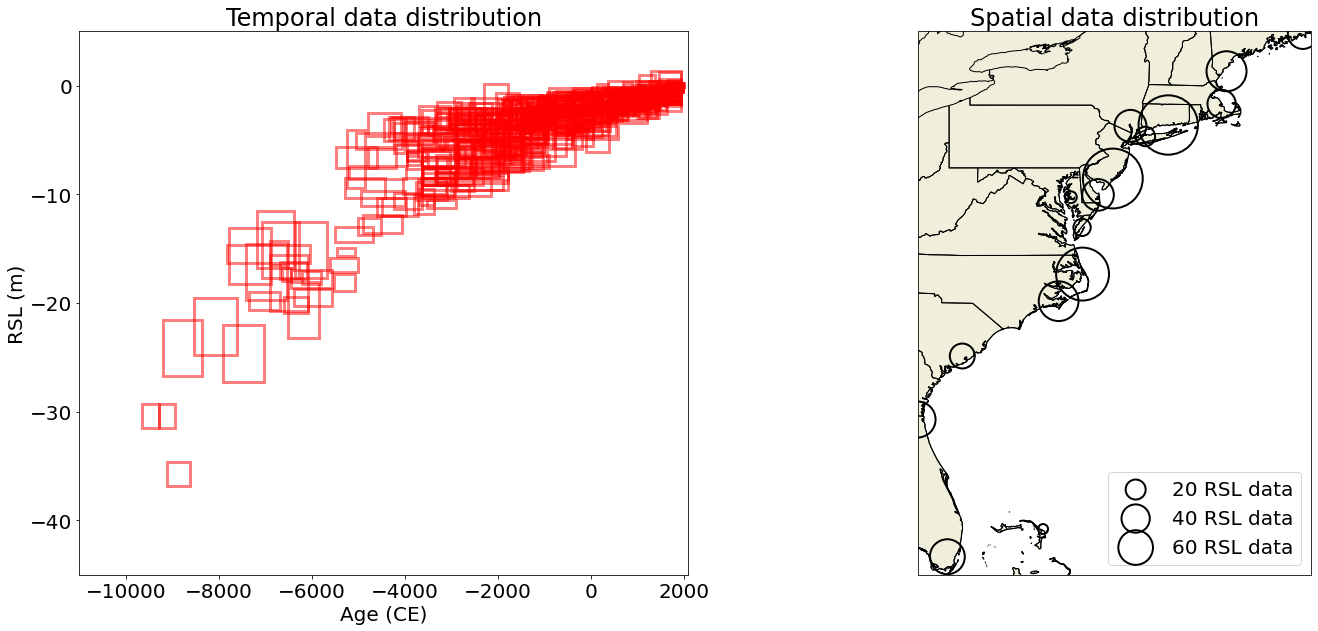

In [2]:
#load data
#ml is marine limiting data, tl is terrestrial limiting data, SLIP is sea-level index points
ml, SLIP, tl = PSTHM.load_regional_rsl_data('../../Data/US_Atlantic_Coast_for_ESTGP.csv')
age, y, y_sigma, age_sigma, rsl_lon,rsl_lat, rsl_region = SLIP

rsl_coord = torch.tensor(np.vstack((rsl_lat,rsl_lon)).T)

#--------Plot data distribution----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
PSTHM.plot_uncertainty_boxes(age,y, age_sigma*2,y_sigma*2,ax=ax)
ax.set_xlim(-11000,2100)
ax.set_ylim(-45,5)
ax.set_title('Temporal data distribution')

#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(rsl_lon),np.max(rsl_lon),np.min(rsl_lat),np.max(rsl_lat)])
rsl_region_index = [np.where(rsl_region==i)[0] for i in np.unique(rsl_region)]
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*20 for x in rsl_region_index],marker='o',facecolor='none',ec='k',
           linewidth=2)
sc = ax2.scatter([0],[0],s=400,label='20 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc2 = ax2.scatter([0],[0],s=800,label='40 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc3 = ax2.scatter([0],[0],s=1200,label='60 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)

ax2.legend(handles=[sc,sc2,sc3], labels=['20 RSL data','40 RSL data','60 RSL data'], loc = 4)

ax2.set_title('Spatial data distribution');

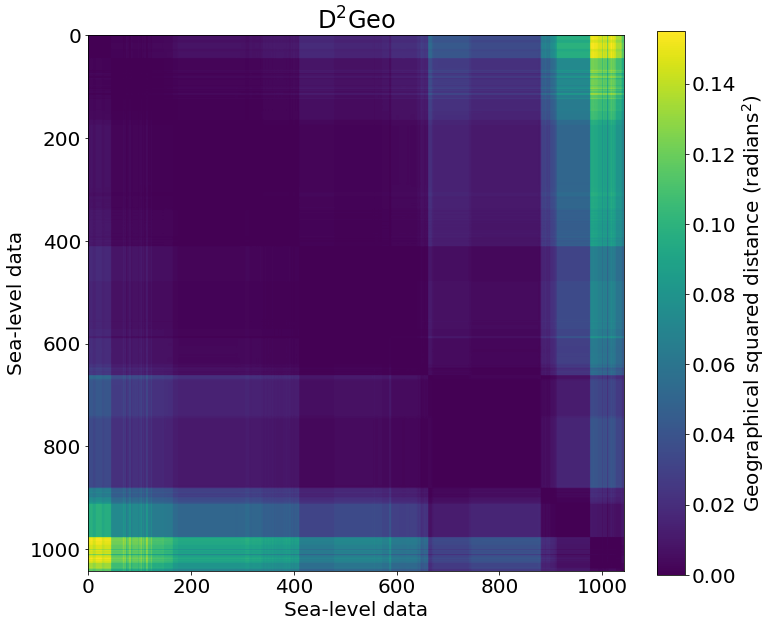

In [21]:
#calculate squared distance matrix
D_geo_sqaure = PSTHM.cal_geo_dist2(rsl_coord)

plt.figure(figsize=(12,10))
plt.imshow(D_geo_sqaure)
plt.colorbar(label='Geographical squared distance (radians$^2$)')
plt.xlabel('Sea-level data')
plt.ylabel('Sea-level data')
plt.title('D$^2$Geo');

**Spatial covariance matrix**

The next step is calculate sptial covariance matrix based on geographical squared distance function. Let's take RBF kernel as an example, which can now be written as:

$$
k_{RBF}(x,x') = \sigma^2\exp\left(-0.5 \times \frac{|x-x'|^2}{l^2}\right)
$$

where $|x-x'|^2$ denotes geographicalsquared distance between each pair of data point based on their coordinate. Let's try it, assumping $\sigma =1$ and $l =0.2$, where $l =0.2$ indicates a sea-level site can correlate with other sea-level sites within 1274 km (6371 x 0.2). Likewise, if $l$ is small, we expect a smaller nearby area to share a similar RSL variation pattern.

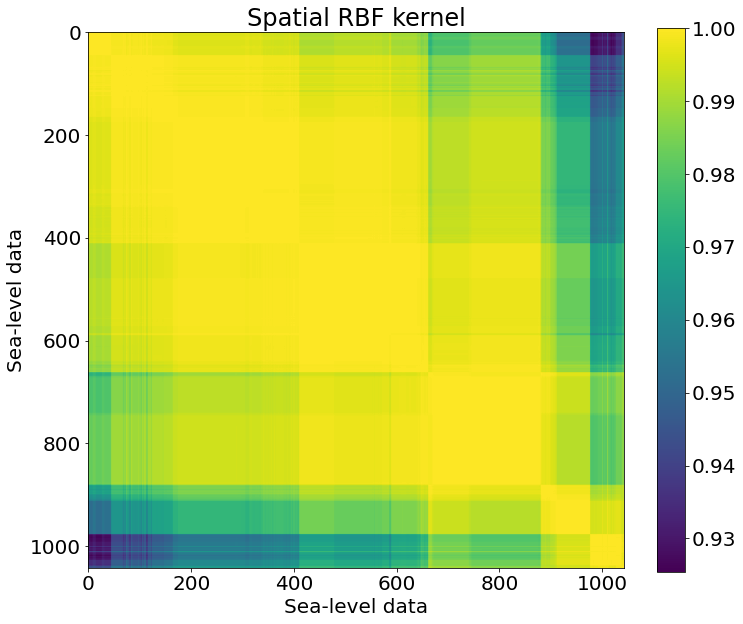

In [22]:
sigma_e = 1
l_e = 1
RBF_geo =  sigma_e**2 * torch.exp(-D_geo_sqaure/(2*l_e**2))
plt.figure(figsize=(12,10))
plt.imshow(RBF_geo)
plt.colorbar()
plt.xlabel('Sea-level data')
plt.ylabel('Sea-level data')
plt.title('Spatial RBF kernel');

### 2. Spatio-temporal kernel


Once we know how to construction a spatial kernel, coupling it with a temporal kernel is very easy: 

$$
k_{RBF}(X,X') = \sigma^2 \exp\left(-0.5 \times \frac{|t-t'|^2}{l_{t}^2}\right) \times \exp\left(-0.5 \times \frac{|x-x'|^2}{l_{s}^2}\right)
$$

where $X$ is a data matrix contains age and geographical location of each data, $\sigma^2$ is a varaince hyperparameter that controls the variability of this covariance function. Note, we only need one variance hyperparameter for this spatio-temporal kernel instead of one for spatial and one for temporal. $l_{t}$ and $l_{s}$ are length scale hyperparameters that deteremines the temporal and spatial length scale of covariance function. Now, this STGP can be written as:

$$
p(f| \sigma, l_{t},l_{s} ,y) \sim GP(0,k_{RBF}(X,X'))
$$

Becuase we are constructing spatio-temporal kernel here, the input data should incorporate spatio-temporal information like:

| Age (CE)  | Laitude (degree) | Longitude (degree)  |
| :-: | :-: | :-: |
| -2576 | 44.629 | -67.382
| -2607 | 44.429 | -68.-1
| ... | ... | ...


Ok, let's try to build our first spatio-temporal kernel with PSTHM. You can build a spatial kernel in PSTHM by:

```python 
spatial_RBF_kernel = global_kernel = PSTHM.RBF(input_dim=1,geo=True,s_lengthscale = torch.tensor(0.2))
```

By setting `geo=True`, the code can compute a RBF kernel for you based on geographical distance, s_lengthscale here indicates the scale lengthscale hyperparameter. 


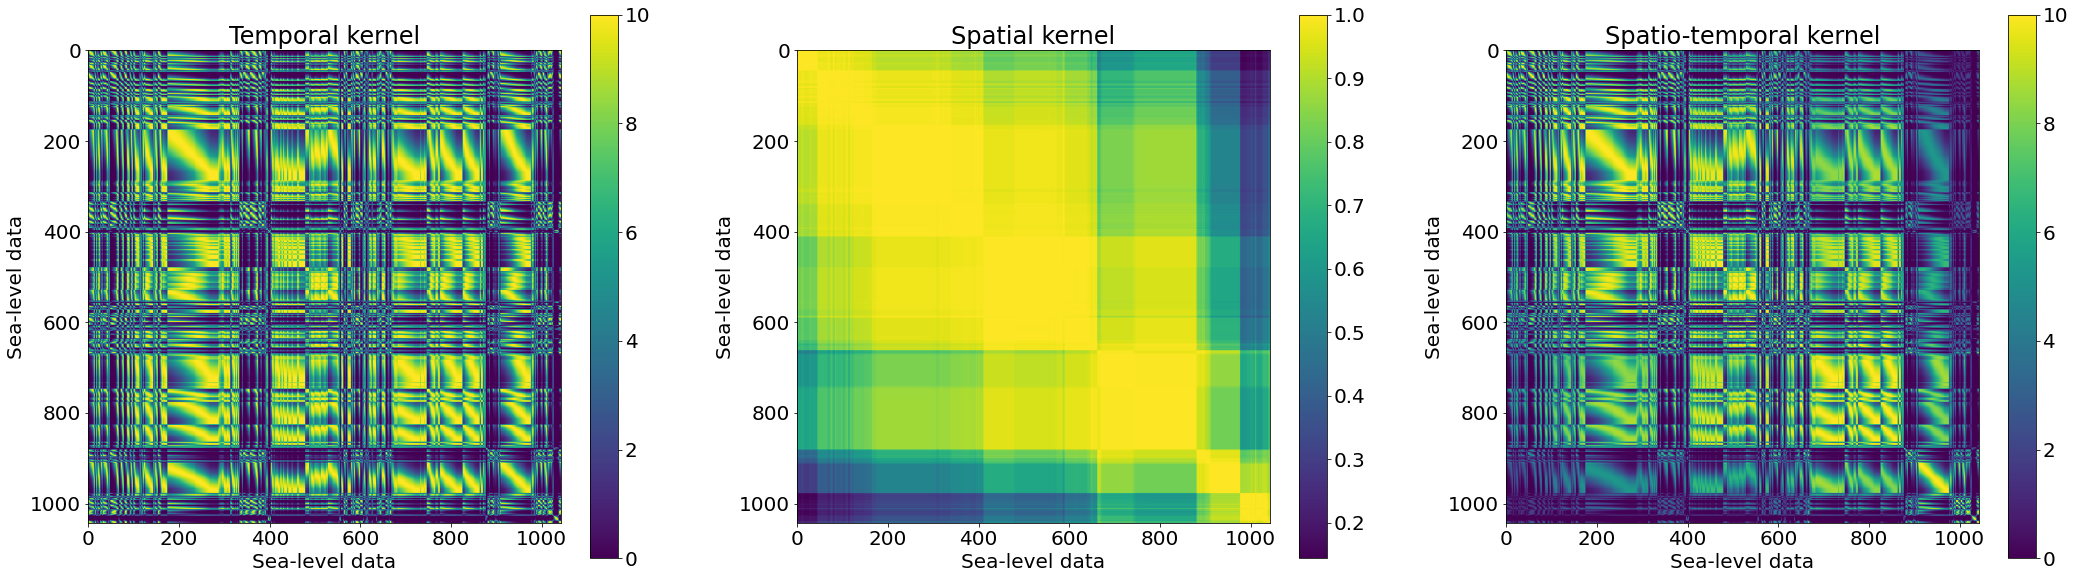

In [23]:
#define input matrix
X = torch.hstack([age[:,None],rsl_coord]) 

pyro.clear_param_store()
#construct spatial and temporal kernels
spatial_RBF_kernel = PSTHM.RBF(input_dim=1,geo=True,s_lengthscale=torch.tensor(0.2))

temporal_RBF_kernel = PSTHM.RBF(input_dim=1,geo=False,lengthscale=torch.tensor(1000.),variance=torch.tensor(10.))

#couple spatial and temporal kernels 
ST_RBF_kernel = gp.kernels.Product(spatial_RBF_kernel, temporal_RBF_kernel)

#calculate spatio-temporal covariance matrix
T_co_matrix = temporal_RBF_kernel(X)
S_co_matrix = spatial_RBF_kernel(X)
ST_co_matrix = ST_RBF_kernel(X)

#plot covariance matrix
plt.figure(figsize=(36,10))
plt.subplot(1,3,1)
plt.imshow(T_co_matrix.detach().numpy())
plt.colorbar()
plt.xlabel('Sea-level data')
plt.ylabel('Sea-level data')
plt.title('Temporal kernel')

plt.subplot(1,3,2)
plt.imshow(S_co_matrix.detach().numpy())
plt.colorbar()
plt.xlabel('Sea-level data')
plt.ylabel('Sea-level data')
plt.title('Spatial kernel')

plt.subplot(1,3,3)
plt.imshow(ST_co_matrix.detach().numpy())
plt.colorbar()
plt.xlabel('Sea-level data')
plt.ylabel('Sea-level data')
plt.title('Spatio-temporal kernel');

You can see the resulting spaio-temporal kernel is influenced by both spatial and temporal kernel now. And then we can start to use this kernel to infer the spatio-temporal sea-level change by optimizing the hyperparameters of this kernel. Because when we do STGP, the data size tend to be much larger than temporal GP, meaning the computaitonal resources required is much larger as well. Therefore, we will use empirical Bayes method to make life easier. You can optimize STGP exactly the same as temporal GP in PSTHM. 

**P.S.** Each iteration for optimizing STGP is slower, so we can reasonably increase the learning rate to make it converge faster, so we can get an optimized model with less iterations. 


  0%|          | 0/500 [00:00<?, ?it/s]

Log Likelihood -4.295
Execution time: 67.920 s


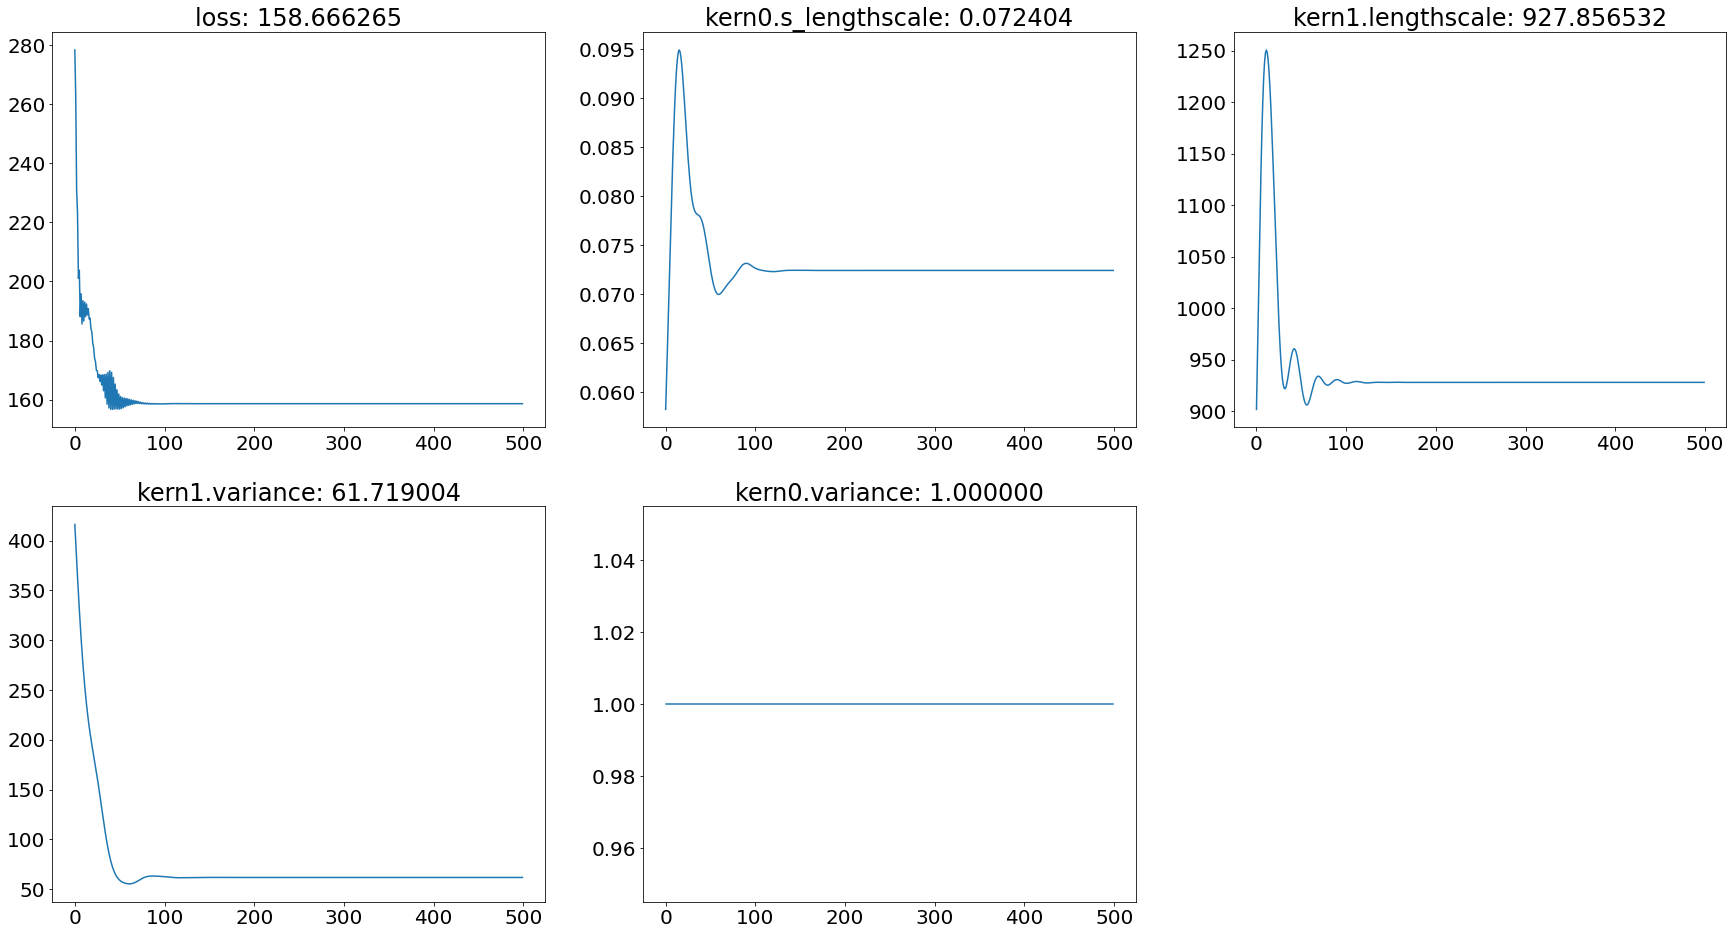

In [26]:
st = time.time() 
pyro.clear_param_store() 

#construct spatial and temporal kernels
spatial_RBF_kernel = PSTHM.RBF(input_dim=1,geo=True)
#note the spatial lengthscale is called s_lengthscale in the PSTHM package
#you can time spatial lengthscale hyperparameter with 6371 to get the geographical distance in km
spatial_RBF_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.3)))

temporal_RBF_kernel = PSTHM.RBF(input_dim=1,geo=False)
temporal_RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(3000.)))
temporal_RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))

#couple spatial and temporal kernels 
ST_RBF_kernel = gp.kernels.Product(spatial_RBF_kernel, temporal_RBF_kernel)

#build a GP regressor with the combined kernel, assuming no chronological uncertainty
gpr = PSTHM.GPRegression_V(X, y, ST_RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma,num_iteration=500,lr=0.05,decay_r=0.8)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plot_track_list(track_list)    
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


Ok, it seems the hyperparameters are concerged pretty well, we can start to generate some inferences on spatio-temporal sea-level change now. To predict RSL, we need to provide an input matrix with the same format as the input data. Let's try to predict a temporal RSL variation for New Jersey first. 

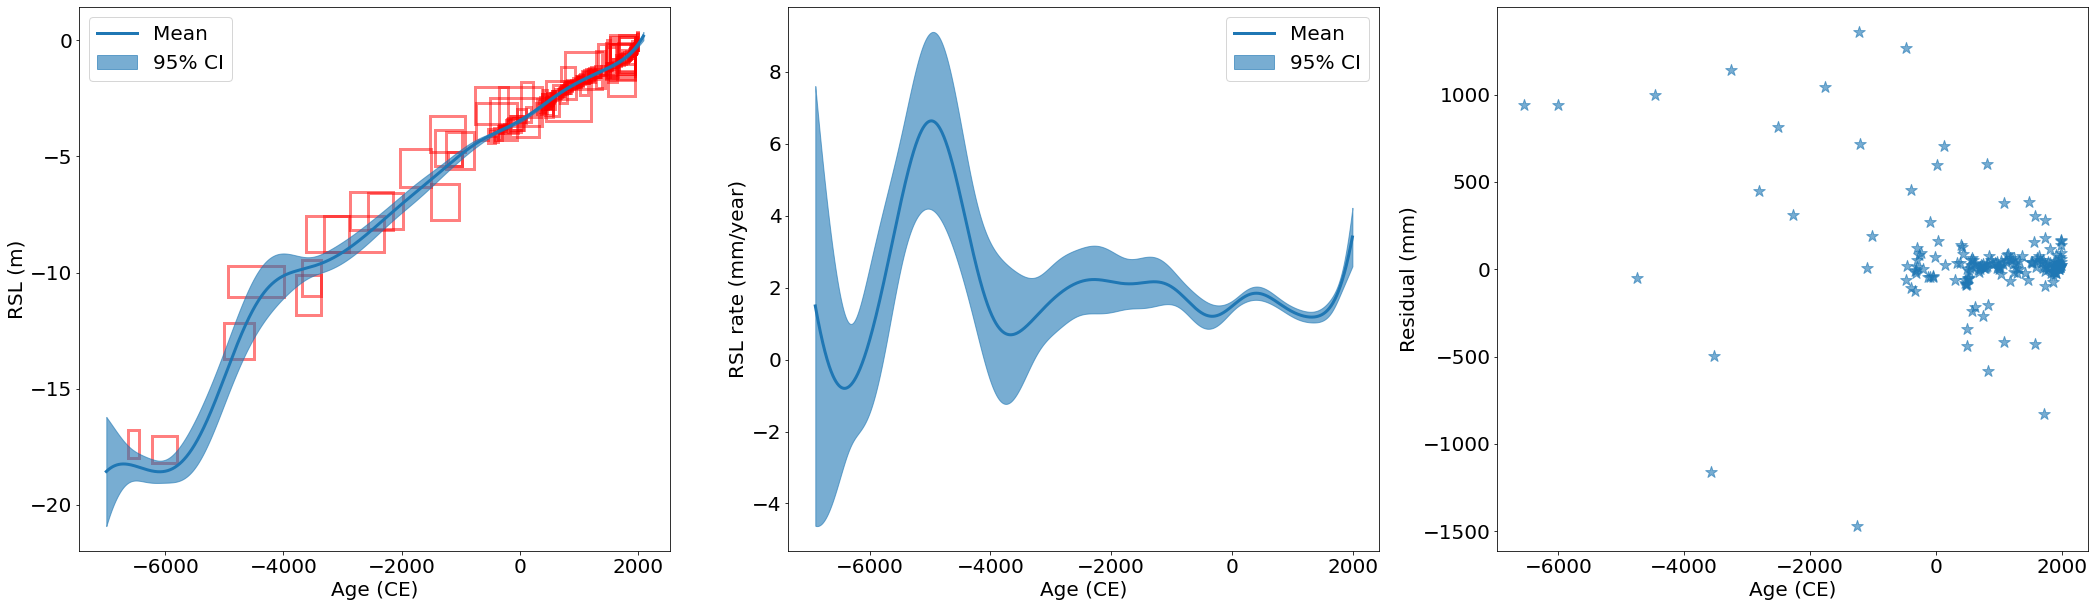

In [27]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2100,5)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.detach().numpy(),y_mean.detach().numpy())

#plot the prediction
axes = PSTHM.plot_tem_regression(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean,y_std,
                          rsl_time,rsl_rate,rsl_rate_sd )


Seems not bad! Because we are using the RBF kernel, RSL changes quite smoothly here. Let's now try to predict spatial pattern of RSL. For sea-level study, visulising the sea-level change rate plot is often more meaningful compared with plotting a single time slice. So let's try plot RSL difference from 10000 to 6000 CE like Fig. 5 in [Ashe et al., 2019](https://www.sciencedirect.com/science/article/pii/S0277379118302130#fig5), which can tell us about the mean RSL between them, RSL change rate, and the uncertainty. 

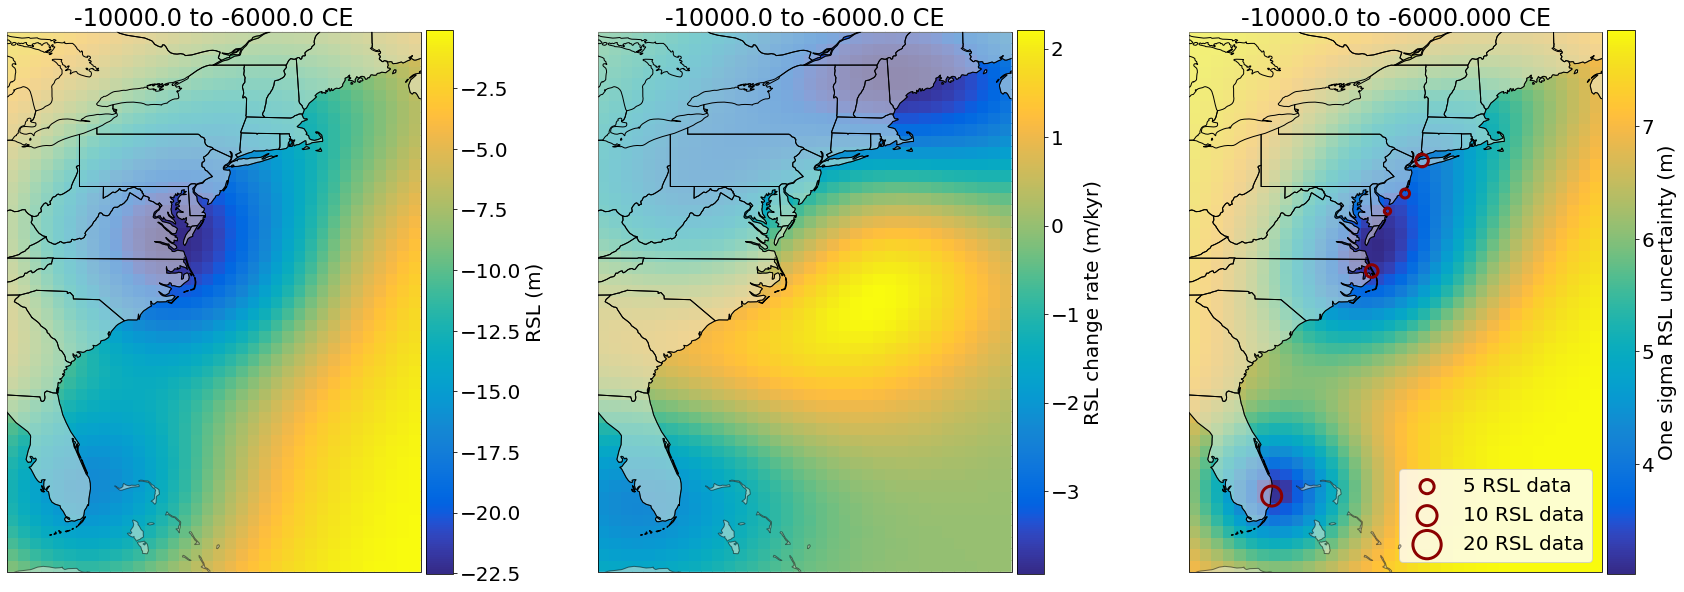

In [28]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM (random assess memeory) will be pretty large 
time_mat = np.arange(-10000,-5900,2000) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)

PSTHM.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap=parula,plot_site=True)

Now, based on spatio-temporal kernel, we can start to infer spatio-temporal properties of sea-level change. We can see that, the spatial predictions show higher precesion (low uncertainty) in locations where sea-level data reconstructed and it will gradually approach to mean function (which we use 0 here) for locations far away from data locations. 

Although this kernel function provides a reasonable performance on sea-level prediction, a single kernel function is too simple to capture complex physical behaviors. So in our next tutorial, we will use multiple kernels. You will learn how to do sea-level predictions with multiple kernels and how to sperate each kernel contribution to the final results.

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.
